This notebook shows the how tallies can be combined (added, subtracted, multiplied, etc.) using the Python API in order to create derived tallies. Since no covariance information is obtained, it is assumed that tallies are completely independent of one another when propagating uncertainties. The target problem is a simple pin cell.

In [1]:
import glob
from IPython.display import Image
import numpy as np

import openmc

## Generate Input Files

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H-1')
b10 = openmc.Nuclide('B-10')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')
zr90 = openmc.Nuclide('Zr-90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pin.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a materials file object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. Our problem will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces -- in this case two cylinders and six reflective planes.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

With the surfaces defined, we can now create cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [7]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = pin_cell_universe

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe, put the geometry into a geometry file, and export it to XML.

In [8]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [9]:
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 5 inactive batches and 15 active batches each with 2500 particles.

In [10]:
# OpenMC simulation parameters
batches = 20
inactive = 5
particles = 2500

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a plot file that we can use to verify that our pin cell geometry was created successfully.

In [11]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [1.26, 1.26]
plot.pixels = [250, 250]
plot.color = 'mat'

# Instantiate a Plots collection and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [12]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

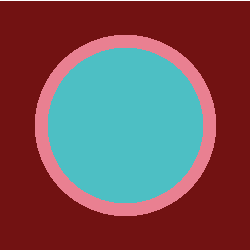

In [13]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice pin cell with fuel, cladding, and water! Before we run our simulation, we need to tell the code what we want to tally. The following code shows how to create a variety of tallies.

In [14]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

In [15]:
# Create Tallies to compute microscopic multi-group cross-sections

# Instantiate energy filter for multi-group cross-section Tallies
energy_filter = openmc.Filter(type='energy', bins=[0., 0.625e-6, 20.])

# Instantiate flux Tally in moderator and fuel
tally = openmc.Tally(name='flux')
tally.filters = [openmc.Filter(type='cell', bins=[fuel_cell.id, moderator_cell.id])]
tally.filters.append(energy_filter)
tally.scores = ['flux']
tallies_file.append(tally)

# Instantiate reaction rate Tally in fuel
tally = openmc.Tally(name='fuel rxn rates')
tally.filters = [openmc.Filter(type='cell', bins=[fuel_cell.id])]
tally.filters.append(energy_filter)
tally.scores = ['nu-fission', 'scatter']
tally.nuclides = [u238, u235]
tallies_file.append(tally)

# Instantiate reaction rate Tally in moderator
tally = openmc.Tally(name='moderator rxn rates')
tally.filters = [openmc.Filter(type='cell', bins=[moderator_cell.id])]
tally.filters.append(energy_filter)
tally.scores = ['absorption', 'total']
tally.nuclides = [o16, h1]
tallies_file.append(tally)

In [16]:
# K-Eigenvalue (infinity) tallies
fiss_rate = openmc.Tally(name='fiss. rate')
abs_rate = openmc.Tally(name='abs. rate')
fiss_rate.scores = ['nu-fission']
abs_rate.scores = ['absorption']
tallies_file += (fiss_rate, abs_rate)

In [17]:
# Resonance Escape Probability tallies
therm_abs_rate = openmc.Tally(name='therm. abs. rate')
therm_abs_rate.scores = ['absorption']
therm_abs_rate.filters = [openmc.Filter(type='energy', bins=[0., 0.625e-6])]
tallies_file.append(therm_abs_rate)

In [18]:
# Thermal Flux Utilization tallies
fuel_therm_abs_rate = openmc.Tally(name='fuel therm. abs. rate')
fuel_therm_abs_rate.scores = ['absorption']
fuel_therm_abs_rate.filters = [openmc.Filter(type='energy', bins=[0., 0.625e-6]),
                               openmc.Filter(type='cell', bins=[fuel_cell.id])]
tallies_file.append(fuel_therm_abs_rate)

In [19]:
# Fast Fission Factor tallies
therm_fiss_rate = openmc.Tally(name='therm. fiss. rate')
therm_fiss_rate.scores = ['nu-fission']
therm_fiss_rate.filters = [openmc.Filter(type='energy', bins=[0., 0.625e-6])]
tallies_file.append(therm_fiss_rate)

In [20]:
# Instantiate energy filter to illustrate Tally slicing
energy_filter = openmc.Filter(type='energy', bins=np.logspace(np.log10(1e-8), np.log10(20), 10))

# Instantiate flux Tally in moderator and fuel
tally = openmc.Tally(name='need-to-slice')
tally.filters = [openmc.Filter(type='cell', bins=[fuel_cell.id, moderator_cell.id])]
tally.filters.append(energy_filter)
tally.scores = ['nu-fission', 'scatter']
tally.nuclides = [h1, u238]
tallies_file.append(tally)

In [21]:
# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [22]:
# Remove old HDF5 (summary, statepoint) files
!rm statepoint.*

# Run OpenMC!
openmc.run()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2016 Massachusetts Institute of Technology
      License:        http://openmc.readthedocs.org/en/latest/license.html
      Version:        0.7.1
      Git SHA1:       df280b60eb1c6d7b7f842e05ede734a4883a0fc8
      Date/Time:      2016-05-05 14:51:45

 ========================>     INITIALIZA

0

## Tally Data Processing

Our simulation ran successfully and created a statepoint file with all the tally data in it. We begin our analysis here loading the statepoint file and 'reading' the results. By default, the tally results are not read into memory because they might be large, even large enough to exceed the available memory on a computer.

In [23]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.20.h5')

We have a tally of the total fission rate and the total absorption rate, so we can calculate k-infinity as:
$$k_\infty = \frac{\langle \nu \Sigma_f \phi \rangle}{\langle \Sigma_a \phi \rangle}$$
In this notation, $\langle \cdot \rangle^a_b$ represents an OpenMC that is integrated over region $a$ and energy range $b$. If $a$ or $b$ is not reported, it means the value represents an integral over all space or all energy, respectively.

In [24]:
# Compute k-infinity using tally arithmetic
fiss_rate = sp.get_tally(name='fiss. rate')
abs_rate = sp.get_tally(name='abs. rate')
keff = fiss_rate / abs_rate
keff.get_pandas_dataframe()

,nuclide,score,mean,std. dev.
0,total,(nu-fission / absorption),1.038387,0.006141


Notice that even though the neutron production rate and absorption rate are separate tallies, we still get a first-order estimate of the uncertainty on the quotient of them automatically!

Often in textbooks you'll see k-infinity represented using the four-factor formula $$k_\infty = p \epsilon f \eta.$$ Let's analyze each of these factors, starting with the resonance escape probability which is defined as $$p=\frac{\langle\Sigma_a\phi\rangle_T}{\langle\Sigma_a\phi\rangle}$$ where the subscript $T$ means thermal energies.

In [25]:
# Compute resonance escape probability using tally arithmetic
therm_abs_rate = sp.get_tally(name='therm. abs. rate')
res_esc = therm_abs_rate / abs_rate
res_esc.get_pandas_dataframe()

,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,0.0,6.250000e-07,total,absorption,0.693337,0.004109


The fast fission factor can be calculated as
$$\epsilon=\frac{\langle\nu\Sigma_f\phi\rangle}{\langle\nu\Sigma_f\phi\rangle_T}$$

In [26]:
# Compute fast fission factor factor using tally arithmetic
therm_fiss_rate = sp.get_tally(name='therm. fiss. rate')
fast_fiss = fiss_rate / therm_fiss_rate
fast_fiss.get_pandas_dataframe()

,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,0.0,6.250000e-07,total,nu-fission,1.203042,0.0076


The thermal flux utilization is calculated as
$$f=\frac{\langle\Sigma_a\phi\rangle^F_T}{\langle\Sigma_a\phi\rangle_T}$$
where the superscript $F$ denotes fuel.

In [27]:
# Compute thermal flux utilization factor using tally arithmetic
fuel_therm_abs_rate = sp.get_tally(name='fuel therm. abs. rate')
therm_util = fuel_therm_abs_rate / therm_abs_rate
therm_util.get_pandas_dataframe()

,energy low [MeV],energy high [MeV],cell,nuclide,score,mean,std. dev.
0,0.0,6.250000e-07,10000,total,absorption,0.748413,0.004723


The final factor is the number of fission neutrons produced per absorption in fuel, calculated as $$\eta = \frac{\langle \nu\Sigma_f\phi \rangle_T}{\langle \Sigma_a \phi \rangle^F_T}$$

In [28]:
# Compute neutrons produced per absorption (eta) using tally arithmetic
eta = therm_fiss_rate / fuel_therm_abs_rate
eta.get_pandas_dataframe()

,energy low [MeV],energy high [MeV],cell,nuclide,score,mean,std. dev.
0,0.0,6.250000e-07,10000,total,(nu-fission / absorption),1.663385,0.011253


Now we can calculate $k_\infty$ using the product of the factors form the four-factor formula.

In [29]:
keff = res_esc * fast_fiss * therm_util * eta
keff.get_pandas_dataframe()

,energy low [MeV],energy high [MeV],cell,nuclide,score,mean,std. dev.
0,0.0,6.250000e-07,10000,total,(((absorption * nu-fission) * absorption) * (n...,1.038387,0.01316


We see that the value we've obtained here has exactly the same mean as before. However, because of the way it was calculated, the standard deviation appears to be larger.

Let's move on to a more complicated example now. Before we set up tallies to get reaction rates in the fuel and moderator in two energy groups for two different nuclides. We can use tally arithmetic to divide each of these reaction rates by the flux to get microscopic multi-group cross sections.

In [30]:
# Compute microscopic multi-group cross-sections
flux = sp.get_tally(name='flux')
flux = flux.get_slice(filters=['cell'], filter_bins=[(fuel_cell.id,)])
fuel_rxn_rates = sp.get_tally(name='fuel rxn rates')
mod_rxn_rates = sp.get_tally(name='moderator rxn rates')

In [31]:
fuel_xs = fuel_rxn_rates / flux
fuel_xs.get_pandas_dataframe()

,cell,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,10000,0.000000e+00,6.250000e-07,(U-238 / total),(nu-fission / flux),6.636968e-07,4.132875e-09
1,10000,0.000000e+00,6.250000e-07,(U-238 / total),(scatter / flux),2.099856e-01,1.232455e-03
2,10000,0.000000e+00,6.250000e-07,(U-235 / total),(nu-fission / flux),3.552458e-01,2.252681e-03
3,10000,0.000000e+00,6.250000e-07,(U-235 / total),(scatter / flux),5.554345e-03,3.265385e-05
4,10000,6.250000e-07,2.000000e+01,(U-238 / total),(nu-fission / flux),7.126668e-03,5.296883e-05
5,10000,6.250000e-07,2.000000e+01,(U-238 / total),(scatter / flux),2.277460e-01,1.003558e-03
6,10000,6.250000e-07,2.000000e+01,(U-235 / total),(nu-fission / flux),8.010911e-03,6.802256e-05
7,10000,6.250000e-07,2.000000e+01,(U-235 / total),(scatter / flux),3.367794e-03,1.443644e-05


We see that when the two tallies with multiple bins were divided, the derived tally contains the outer product of the combinations. If the filters/scores are the same, no outer product is needed. The `get_values(...)` method allows us to obtain a subset of tally scores. In the following example, we obtain just the neutron production microscopic cross sections.

In [32]:
# Show how to use Tally.get_values(...) with a CrossScore
nu_fiss_xs = fuel_xs.get_values(scores=['(nu-fission / flux)'])
print(nu_fiss_xs)

[[[  6.63696783e-07]
  [  3.55245846e-01]]

 [[  7.12666800e-03]
  [  8.01091088e-03]]]


The same idea can be used not only for scores but also for filters and nuclides.

In [33]:
# Show how to use Tally.get_values(...) with a CrossScore and CrossNuclide
u235_scatter_xs = fuel_xs.get_values(nuclides=['(U-235 / total)'], 
                                scores=['(scatter / flux)'])
print(u235_scatter_xs)

[[[ 0.00555435]]

 [[ 0.00336779]]]


In [34]:
# Show how to use Tally.get_values(...) with a CrossFilter and CrossScore
fast_scatter_xs = fuel_xs.get_values(filters=['energy'], 
                                     filter_bins=[((0.625e-6, 20.),)], 
                                     scores=['(scatter / flux)'])
print(fast_scatter_xs)

[[[ 0.22774598]
  [ 0.00336779]]]


A more advanced method is to use `get_slice(...)` to create a new derived tally that is a subset of an existing tally. This has the benefit that we can use `get_pandas_dataframe()` to see the tallies in a more human-readable format.

In [35]:
# "Slice" the nu-fission data into a new derived Tally
nu_fission_rates = fuel_rxn_rates.get_slice(scores=['nu-fission'])
nu_fission_rates.get_pandas_dataframe()

,cell,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,10000,0.000000e+00,6.250000e-07,U-238,nu-fission,0.000002,7.473789e-09
1,10000,0.000000e+00,6.250000e-07,U-235,nu-fission,0.861547,4.131310e-03
2,10000,6.250000e-07,2.000000e+01,U-238,nu-fission,0.082356,5.560461e-04
3,10000,6.250000e-07,2.000000e+01,U-235,nu-fission,0.092574,7.315442e-04


In [36]:
# "Slice" the H-1 scatter data in the moderator Cell into a new derived Tally
need_to_slice = sp.get_tally(name='need-to-slice')
slice_test = need_to_slice.get_slice(scores=['scatter'], nuclides=['H-1'],
                                     filters=['cell'], filter_bins=[(moderator_cell.id,)])
slice_test.get_pandas_dataframe()

,cell,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,10002,1.000000e-08,1.080060e-07,H-1,scatter,4.599225,0.015973
1,10002,1.080060e-07,1.166529e-06,H-1,scatter,2.037260,0.011236
2,10002,1.166529e-06,1.259921e-05,H-1,scatter,1.662552,0.010280
3,10002,1.259921e-05,1.360790e-04,H-1,scatter,1.872201,0.012136
4,10002,1.360790e-04,1.469734e-03,H-1,scatter,2.080459,0.013155
5,10002,1.469734e-03,1.587401e-02,H-1,scatter,2.154996,0.011975
6,10002,1.587401e-02,1.714488e-01,H-1,scatter,2.218740,0.008528
7,10002,1.714488e-01,1.851749e+00,H-1,scatter,2.010517,0.009187
8,10002,1.851749e+00,2.000000e+01,H-1,scatter,0.372022,0.003196
